In [17]:
#Celso Henrique 
# Import all necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
import seaborn as sns
from scipy.special import erfc
from sklearn.model_selection import GridSearchCV

In [18]:
N = 1000000

In [19]:
def mod(V):
    ip = np.zeros((len(V),1),dtype=complex)
    inc = 0
    for v in V:
        if(v==0):
            ip[inc] = -1.0 - 1j*1.0
        elif(v==1):
            ip[inc] = -1.0 + 1j*1.0
        elif(v==2):
            ip[inc] = 1.0 - 1j*1.0
        else:
            ip[inc] = 1.0 + 1j*1.0
        inc += 1
    # Normalization of energy to 1.
    s = (1/np.sqrt(2))*ip;
    return s

def demod(c):
    c_seq = mod(np.array([0,1,2,3]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [20]:
# Create Es/N0 vector.

EsN0dB = np.arange(-2,22,2)
ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))

for idx in range(0,len(EsN0dB)):
    print('Es/N0 dB:', EsN0dB[idx])
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    
    # Generate N binary symbols.
    bits = np.random.randint(0,4,(N,1))
    
     # Modulate binary stream into BPSK symbols.
    s = mod(bits)
    s = s.reshape(N,1)
    bits = bits.reshape(N,1)
    
    # Generate noise vector with unitary variance.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
    # Pass symbols through AWGN channel.
    y = s + np.sqrt(EsN0Lin)*noise
    
    # Split array into random train and test subsets.
    s_test, s_train, y_test, y_train, bits_test, bits_train = train_test_split(s, y, bits, random_state=42)
    
    Y = np.c_[y_train.real,y_train.imag]
    
    
    # Create an instance of Neighbours Classifier and fit the data.
    knn = KNeighborsClassifier(n_neighbors=16, weights='distance')
    # Train the classifier.
    knn.fit(Y, bits_train.ravel())
    
    # Prediction.
    detected = knn.predict(np.c_[y_test.real,y_test.imag])

    # Simulated BPSK SER.
    error = 0
    for i in range(0,len(detected)):
        if(detected[i] != bits_test[i,0]):
            error = error + 1
    
    ser_simu[idx] = 1.0 * error / len(bits_test)
    
    # Theoretical BPSK BER.
    EsN0 = 10.0**(EsN0dB[idx]/10.0)
    ser_theo[idx] = erfc( np.sqrt( 0.5*(10.0**(EsN0dB[idx]/10.0)) ) ) - (1/4)*(erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))))**2.0
       
    
    
    
   
    
    # Prediction.
    detected = knn.predict(np.c_[y_test.real,y_test.imag])

    # Simulated BPSK SER.
    error = 0
    for i in range(0,len(detected)):
        if(detected[i] != bits_test[i,0]):
            error = error + 1
    
    ser_simu[idx] = 1.0 * error / len(bits_test)
    
    # Theoretical BPSK BER.
    EsN0 = 10.0**(EsN0dB[idx]/10.0)
    ser_theo[idx] = erfc( np.sqrt( 0.5*(10.0**(EsN0dB[idx]/10.0)) ) ) - (1/4)*(erfc(np.sqrt(0.5*(10.0**(EsN0dB[idx]/10.0)))))**2.0

Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10
Es/N0 dB: 12
Es/N0 dB: 14
Es/N0 dB: 16
Es/N0 dB: 18
Es/N0 dB: 20


In [21]:
# Print Es/N0 versus BER values.
for i in range(0,len(ser_simu)): print('Es/N0:%d \t- SER: %e' % (EsN0dB[i], ser_simu[i]))

Es/N0:-2 	- SER: 4.159533e-01
Es/N0:0 	- SER: 3.172160e-01
Es/N0:2 	- SER: 2.133533e-01
Es/N0:4 	- SER: 1.186827e-01
Es/N0:6 	- SER: 4.908533e-02
Es/N0:8 	- SER: 1.294533e-02
Es/N0:10 	- SER: 1.676000e-03
Es/N0:12 	- SER: 7.333333e-05
Es/N0:14 	- SER: 0.000000e+00
Es/N0:16 	- SER: 0.000000e+00
Es/N0:18 	- SER: 0.000000e+00
Es/N0:20 	- SER: 0.000000e+00


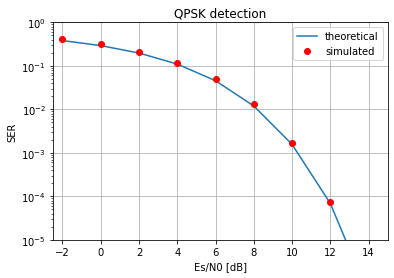

In [24]:
# Plot Es/N0 versus SER values.
plt.plot(EsN0dB, ser_theo, label='theoretical')
plt.plot(EsN0dB, ser_simu, 'ro', label='simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('QPSK detection')
plt.legend()
plt.xlim([-2.5, 15])
plt.ylim([1e-5, 1])
plt.show()

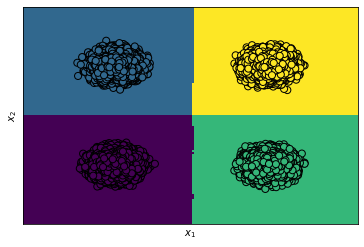

In [23]:
x = np.concatenate([np.real(y), np.imag(y)],axis=1)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z =  knn.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z)#, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], marker='o', c=bits.reshape(N,), s=50, edgecolor='k')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.grid()

plt.show()